## Package import

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from time import sleep

In [7]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.gaussian_process import GaussianProcessRegressor

In [1]:
import psi

## Create the mock observations

In [3]:
yerr_param = [0.0, 2.5]#[0.1, 0.5]
line  = psi.sample_models.noisy_line(yerr_param=yerr_param)
xs    = line.xs()
y_obs = line.observation()

## BOLFI

### 1 parameter 

#### Define the simulators and the distance metric

In [4]:
simulator = lambda x: line.simulator(x, line.true_intercept)
distance  = psi.distances.euclidean

In [5]:
prior  = {'m': 'uniform'}#, 'c': 'uniform'}
bounds = {'m': [-2.5, 0.5]}#, 'c': [0,10]}
gpr = GaussianProcessRegressor()

#### Running BOLFI 

In [8]:
rn = psi.BOLFI_1param(simulator, distance, y_obs, prior, bounds, N_init=5, gpr=gpr, max_iter=50)
rn.run()

0.023115120616650642

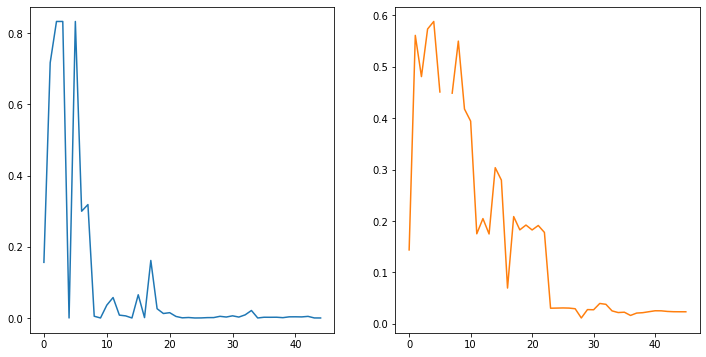

In [25]:
## JS over iterations
plt.rcParams['figure.figsize'] = [12, 6]

plt.subplot(121)
plt.plot(rn.successive_JS_dist, c='C0')
plt.subplot(122)
plt.plot(rn.cv_JS_dist['mean'], c='C1')

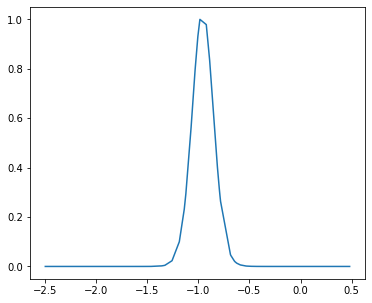

In [29]:
## Posterior plot
plt.rcParams['figure.figsize'] = [6, 5]

plt.plot(rn.xout, rn.post_mean_normmax[-1])

### 2 parameter 

#### Define the simulators and the distance metric

In [30]:
simulator = lambda x: line.simulator(x[0], x[1])
distance  = psi.distances.euclidean

#### Running BOLFI 

In [31]:
prior  = {'m': 'uniform', 'c': 'uniform'}
bounds = {'m': [-2.5, 0.5], 'c': [0,10]}
gpr = GaussianProcessRegressor()

In [40]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.model_selection import KFold
from scipy.integrate import simps
from psi import distances
from psi import bayesian_optimisation as bopt
from psi import helper_functions as hf 

def grid_bounds(bounds, n_grid=20):
	def add_dim_to_grid(bound, n_grid=100, init_grid=None):
		if init_grid is None:
			final_grid = np.linspace(bound[0], bound[1], n_grid)
		else:
			final_grid = [np.append(gg,nn) if type(gg)==np.ndarray else [gg,nn] for gg in init_grid for nn in np.linspace(bound[0], bound[1], n_grid)]
		return np.array(final_grid)
	ndim_param = bounds.shape[0]
	grid = add_dim_to_grid(bounds[0], n_grid=n_grid, init_grid=None)
	if ndim_param==1: return grid
	for bound in bounds[1:]:
		grid = add_dim_to_grid(bound, n_grid=n_grid, init_grid=grid)
	return grid

class BOLFI:
	def __init__(self, simulator, distance, observation, prior, bounds, N_init=5, gpr=None, max_iter=100, cv_JS_tol=0.01, successive_JS_tol=0.01):
		self.N_init  = N_init
		self.gpr = GaussianProcessRegressor() if gpr is None else gpr
		self.simulator = simulator
		self.distance  = distance
		self.y_obs = observation
		self.param_names = [kk for kk in prior]
		self.bounds = np.array([bounds[kk] for kk in self.param_names])
		self.sample_prior = {}
		for i,kk in enumerate(self.param_names):
			self.sample_prior[kk] = lambda: np.random.uniform(low=self.bounds[i,0], high=self.bounds[i,1], size=1)
		self.xout = grid_bounds(self.bounds, n_grid=20)
		self.max_iter = max_iter
		self.params = np.array([])
		self.post_mean_unnorm  = []
		self.post_mean_normmax = []
		self.cv_JS_tol  = cv_JS_tol
		self.cv_JS_dist = {'mean':[], 'std':[]}
		self.successive_JS_tol  = successive_JS_tol
		self.successive_JS_dist = []		
	def run(self, max_iter=None):
		if max_iter is not None: self.max_iter = max_iter
		gpr = self.gpr
		start_iter = self.params.size
		def fit_model(params, dists):
			X = params.reshape(-1,1) if params.ndim==1 else params
			y = dists.reshape(-1,1) if dists.ndim==1 else dists

			n_cv = 10 if y.size>20 else 5
			kf = KFold(n_splits=n_cv)
			pdfs = []
			for train_index, test_index in kf.split(X):
				X_train, X_test = X[train_index], X[test_index]
				y_train, y_test = y[train_index], y[test_index]
				gpr.fit(X_train, y_train)
				y_pred, y_std = gpr.predict(self.xout, return_std=True)
				unnorm_post_mean = np.exp(-y_pred/2.)
				pdfs.append(unnorm_post_mean)
		
			cvdist = np.array([distances.jensenshannon(p1,p2) for p1 in pdfs for p2 in pdfs])
			self.cv_JS_dist['std'].append(cvdist.std())
			self.cv_JS_dist['mean'].append(cvdist.mean())
			y_pred, y_std = gpr.predict(self.xout, return_std=True)
			unnorm_post_mean = np.exp(-y_pred/2.)
			self.post_mean_unnorm.append(unnorm_post_mean)
			self.post_mean_normmax.append(unnorm_post_mean/unnorm_post_mean.max())
			return cvdist.std()
		# Initialization
		if start_iter<self.N_init:
			params  = np.array([[self.sample_prior[kk]()[0] for kk in self.param_names] for i in range(self.N_init)]).squeeze()
			sim_out = np.array([self.simulator(i) for i in params])
			dists   = np.array([self.distance(self.y_obs, ss) for ss in sim_out])
			self.params = params
			self.dists  = dists
			msg = fit_model(self.params, self.dists)
			hf.loading_verbose(str(msg))
		"""
		# Further sampling
		start_iter = self.params.size
		condition1, condition2 = False, False
		for n_iter in range(start_iter,self.max_iter):
			if condition1 and condition2: break
			X = self.params.reshape(-1,1) if self.params.ndim==1 else self.params
			y = self.dists.reshape(-1,1) if self.dists.ndim==1 else self.dists
			X_next = bopt.propose_location(bopt.expected_improvement, X, y, gpr, self.bounds)

			y_next = self.simulator(X_next)
			d_next = self.distance(self.y_obs, y_next)

			self.params = np.append(self.params, X_next) 
			self.dists  = np.append(self.dists, d_next)
			msg = fit_model(self.params, self.dists)
			hf.loading_verbose(str(msg))
			sucJSdist   = distances.jensenshannon(self.post_mean_normmax[-1], self.post_mean_normmax[-2])[0]
			self.successive_JS_dist.append(sucJSdist)
			condition1 = self.cv_JS_dist['mean'][-1]+self.cv_JS_dist['std'][-1]<self.cv_JS_tol
			condition2 = self.successive_JS_dist[-1]<self.successive_JS_tol
		"""



In [35]:
rn = BOLFI(simulator, distance, y_obs, prior, bounds, N_init=5, gpr=gpr)
rn.run()

0.14758054478784244

In [36]:
rn.cv_JS_dist

{'mean': [0.10123962129692639], 'std': [0.14758054478784244]}

In [52]:
		# Further sampling
		start_iter = rn.params.size
		condition1, condition2 = False, False
		for n_iter in range(start_iter,rn.max_iter):
			if condition1 and condition2: break
			X = rn.params.reshape(-1,1) if rn.params.ndim==1 else rn.params
			y = rn.dists.reshape(-1,1) if rn.dists.ndim==1 else rn.dists
			X_next = bopt.propose_location(bopt.expected_improvement, X, y, gpr, rn.bounds); print(X_next)

			y_next = self.simulator(X_next)
			d_next = self.distance(self.y_obs, y_next)

			self.params = np.append(self.params, X_next) 
			self.dists  = np.append(self.dists, d_next)
			msg = fit_model(self.params, self.dists)
			hf.loading_verbose(str(msg))
			sucJSdist   = distances.jensenshannon(self.post_mean_normmax[-1], self.post_mean_normmax[-2])[0]
			self.successive_JS_dist.append(sucJSdist)
			condition1 = self.cv_JS_dist['mean'][-1]+self.cv_JS_dist['std'][-1]<self.cv_JS_tol
			condition2 = self.successive_JS_dist[-1]<self.successive_JS_tol


[[0.1241482 ]
 [5.22631637]]


NameError: name 'self' is not defined